In [ ]:
!wget https://pyeeg.googlecode.com/files/pyeeg_v.0.02_r2.py

In [ ]:
!mv pyeeg_v.0.02_r2.py pyeeg.py

In [27]:
import numpy as np
import numpy.random as rng

import theano
import theano.tensor as T

from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sb
sb.set()

import pandas as pd
import timeit
from pyeeg import embed_seq

/home/adrian/Envs/scyfer/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


http://deeplearning.net/software/theano/library/scan.html  
http://deeplearning.net/tutorial/code/lstm.py  
http://www.christianherta.de/lehre/dataScience/machineLearning/neuralNetworks/LSTM.php  
http://www.wildml.com/2015/10/recurrent-neural-network-tutorial-part-4-implementing-a-grulstm-rnn-with-python-and-theano/  
http://arxiv.org/pdf/1503.04069.pdf  
http://jmlr.org/proceedings/papers/v37/jozefowicz15.pdf

In [18]:
sunspots = sm.datasets.sunspots.load_pandas().data.astype('float32')
scaler = StandardScaler()
ts_train = scaler.fit_transform(sunspots.SUNACTIVITY)
x_train = embed_seq(ts_train, 1, 11)

rng = np.random
dtype = theano.config.floatX
n_samples, nn_input_dim = x_train.shape
nn_output_dim = nn_input_dim
n_h_dim = n_c_dim = 5

# Initialize Theano symbolic variables for the LSTM memory cell
inputs = T.matrix(dtype=dtype)
targets = T.matrix(dtype=dtype)
num_epochs = T.iscalar()

In [19]:
# weights generator
def ortho_weights(sizeX, sizeY):
    W = rng.uniform(low=-1., high=1.,  size=(sizeX, sizeY)).astype(dtype)
    s = np.linalg.svd(W)[1]
    W /= s[0]
    return W.astype(dtype)

In [20]:
# parameters for in, out & forget gates:
Whx = theano.shared(ortho_weights(3*n_h_dim, nn_input_dim), name='Whx')  # stacked input-to-hidden unit weights
Whh = theano.shared(ortho_weights(3*n_h_dim, n_h_dim), name='Whh')      # stacked hidden-to-hidden unit weights
bh = theano.shared(np.hstack((np.zeros(2*n_h_dim,dtype=dtype), 
                              np.ones((n_h_dim),dtype=dtype))), name='bh')                         # vector of stacked biases
# parameters for memory cell
Wcx = theano.shared(ortho_weights(n_h_dim, nn_input_dim), name='Wcx')  # stacked input-to-hidden unit weights
Wch = theano.shared(ortho_weights(n_h_dim, n_h_dim), name='Wch')      # stacked hidden-to-hidden unit weights
bc = theano.shared(np.zeros(n_h_dim, dtype=dtype), name='bc')     
# parameters for autoeconder ouput
Wyh = theano.shared(ortho_weights(nn_output_dim, n_h_dim), name='Wyh')  # stacked input-to-hidden unit weights
by = theano.shared(np.zeros(nn_output_dim, dtype=dtype), name='by')   

# initial values for h and c
c0 = theano.shared(value=np.zeros(n_h_dim, dtype=dtype)) # vector of initial values for memory cells
h0 = T.tanh(c0)

# deep learning LSTM tutorial, when used directly in scan's outputs_info for h0, c0
# [tensor.alloc(0., n_samples, n_h_dim), tensor.alloc(0., n_samples, n_h_dim)]

pars = [Whx, Whh, Wcx, Wch, Wyh, bh, bc, by]

# def train_model

def lstm_Step(x_t, h_tm1, c_tm1, Whx, Whh, Wcx, Wch, Wyh, bh, bc, by):
    # preact = x_t + h_tm1 # tensor.dot(h_, tpars[_p(prefix, 'U')]) orthogonalized h
    preact = Whx.dot(x_t) + Whh.dot(h_tm1) + bh
    g = T.nnet.sigmoid(preact)
    i, o, f = g[:n_h_dim], g[n_h_dim:2*n_h_dim], g[2*n_h_dim:]
    c_in = T.tanh(Wcx.dot(x_t) + Wch.dot(h_tm1) + bc)
    c = f * c_tm1 + i * c_in
    h = o * T.tanh(c)
    y = Wyh.dot(h) + by # regression
    # RNN classification output y = T.nnet.softmax(Wyh.dot(h) + by)[0]
    return [h, c, y]

[h_vals, _, y_vals] = theano.scan(fn=lstmStep,
                                  sequences=[dict(input=inputs, taps=[0])],
                                  outputs_info=[h0, c0, None],
                                  non_sequences=[Whx, Whh, Wcx, Wch, Wyh, bh, bc, by],
                                  strict=True)[0]

#  + weight_regularization * (w ** 2).sum() + hidden_regularization * T.abs(w).sum() ADD all weights
cost = ((inputs - y_vals)**2).mean(axis=0).sum() # regression

# learning rate
lr = 0.1
learning_rate = theano.shared(np.cast[dtype](lr))

# gradients
gpars = []
for par in pars:
    gpar = T.grad(cost, par)
    gpars.append(gpar)

# pars updates
updates=[]
for par, gpar in zip(pars, gpars):
    updates.append((par, par - gpar * learning_rate))

# compile traning function
learn_lstm_rnn = theano.function(inputs=[inputs],
                                 outputs=[h_vals, cost],
                                 updates=updates,
                                 allow_input_downcast=True)

# prediction function
forecast = Wyh.dot(h_vals.T).T+ by
predict_lstm_rnn = theano.function(inputs=[inputs],
                                   outputs=forecast,
                                   allow_input_downcast=True
                                  )

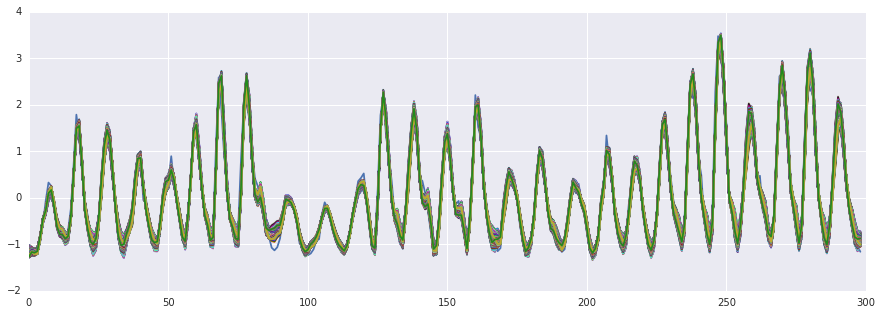

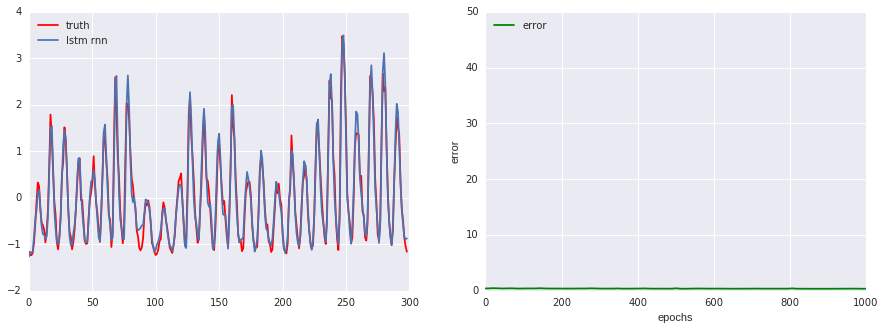

In [37]:
# visualize training epochs
plt.figure(0, figsize=[15,5])
plt.plot(x_train[:,-1])
n_epochs=1000
train_errors = []
for x in xrange(n_epochs):
    train_errors.append(np.asscalar(learn_lstm_rnn(x_train)[1]))
    if x % 100:
        plt.plot(predict_lstm_rnn(x_train)[:,-1], color=np.random.rand(3,1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5], num=1)
ax1.plot(x_train[:,-1], 'r-', label='truth')
ax1.plot(predict_lstm_rnn(x_train)[:,-1], label='lstm rnn')
ax1.legend(loc=2)
ax2.plot(np.arange(n_epochs), train_errors, 'g-')
ax2.set_xlabel('epochs')
ax2.set_ylabel('error')
ax2.set_ylim(0., 50)
ax2.legend(['error'], loc=2)
fig.show()